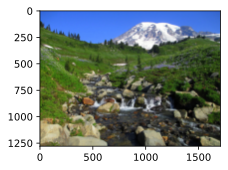

In [1]:
# 首先，我们读取内容和风格图像。 从打印出的图像坐标轴可以看出，它们的尺寸并不一样。
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
d2l.set_figsize()
content_img = d2l.Image.open('images/rainier.jpg')
d2l.plt.imshow(content_img)

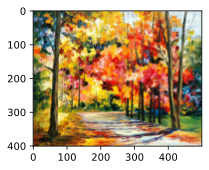

In [2]:
style_img = d2l.Image.open('images/autumn-oak.jpg')
d2l.plt.imshow(style_img)

In [4]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    # 由于图像打印函数要求每个像素的浮点数值在0～1之间，我们对小于0和大于1的值分别取0和1，且将通道维度放在最后，方便计算
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    # 转换为PIL图像
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\15349816070/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


为了抽取图像的内容特征和风格特征，我们可以选择VGG网络中某些层的输出。 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。 为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。 我们还从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为风格层。 正如 7.2节中所介绍的，VGG网络使用了5个卷积块。 实验中，我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。 这些层的索引可以通过打印pretrained_net实例获取。

In [6]:
pretrained_net.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。 下面构建一个新的网络net，它只保留需要用到的VGG的所有层。

In [9]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(style_layers + content_layers) + 1)])
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

给定输入X，如果我们简单地调用前向传播net(X)，只能获得最后一层的输出。 由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。

In [10]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in content_layers:
            contents.append(X)
        if i in style_layers:
            styles.append(X)
    return contents, styles

下面定义两个函数：get_contents函数对内容图像抽取内容特征； get_styles函数对风格图像抽取风格特征。 因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和风格特征。 由于合成图像是风格迁移所需迭代的模型参数，我们只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和风格特征。

In [11]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

定义损失函数

In [12]:
# 内容损失
'''
在 PyTorch 中，.detach() 方法将张量从计算图中分离出来，使其不再参与梯度计算。在 content_loss() 函数中，Y 参数是训练期间固定的目标值，因此不需要参与梯度计算。因此，我们可以将 Y 从计算图中分离出来，以提高效率。
但是，将 Y_hat 从计算图中分离出来会增加一层额外的计算，因此会降低效率。因此，在 content_loss() 函数中，我们不需要将 Y_hat 从计算图中分离出来。
'''
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

In [13]:
# 风格损失
'''
自然地，风格损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与风格图像的风格层输出。这里假设基于风格图像的格拉姆矩阵gram_Y已经预先计算好了。
'''
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [21]:
# 全变分损失
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

风格转移的损失函数是内容损失、风格损失和总变化损失的加权和。 通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。

In [22]:
content_weight, style_weight, tv_weight = 1, 1e4, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y  in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [23]:
# 初始化合成图像
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [24]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [25]:
# 训练
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

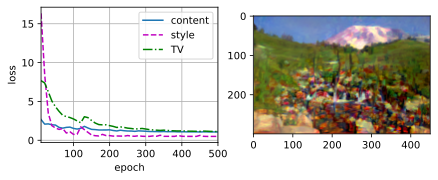

In [27]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)